# 4. 인공 신경망

인공 신경망은 사람의 신경망을 모사하여 만든 예측 도구이다. 기본적으로 하나의 레이어에 다수의 노드를 가지고 있으며 여러 개의 레이어가 쌓인 신경망을
깊은 신경망이라고 한다. 이 때, 깊은 신경망을 이용하여 모델을 학습 시키는 방법을 딥러닝이라고 한다.

In [ ]:
import pandas as pd # 데이터프레임 형태를 다룰 수 있는 라이브러리
import numpy as np
from sklearn.model_selection import train_test_split # 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.

# ANN
import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다. (신경망 기술 등)

# Plot
import matplotlib.pyplot as plt # 시각화 도구

## 4.1 데이터 불러오기

In [ ]:
# 2021.12 기존 데이터를 스케일링 데이터로 업데이트 했습니다.
df = pd.read_csv('./data/reg.csv', index_col=[0]) # index_col=[0]: index가 피쳐로 들어오는 것을 방지

In [ ]:
# 데이터프레임 보여주기
# df.head()는 상위 5줄만 보여준다.
# df.head(10) 괄호 안에 숫자 10을 넣으면 10줄을 보여준다. 
df.head(10) 

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333
5,0.038651,0.019568,0.139449,0.719852,0.560581,0.610531,0.578661,0.387926,0.133629,0.072967,0.514078,0.986385,0.127396,0.526667
6,0.033301,0.136658,0.336651,0.274996,0.472140,0.331155,0.643546,0.661869,0.270651,0.239929,0.475964,0.993516,0.300521,0.397778
7,0.026858,0.151993,0.300627,0.115449,0.463345,0.532618,0.938389,0.465781,0.139893,0.238901,0.243669,0.991425,0.431171,0.491111
8,0.021739,0.132378,0.259349,0.488716,0.389581,0.411536,0.984672,0.526151,0.201324,0.236329,0.306712,0.965204,0.767177,0.255556
9,0.014588,0.144471,0.331099,0.759479,0.696532,0.334544,0.834204,0.611416,0.174935,0.237351,0.437982,0.967070,0.445798,0.308889


## 4.2 데이터 변수와 타겟값 나누기

In [ ]:
# 데이터를 넘파이 배열로 만들기
X = df.drop('Price', axis=1).to_numpy() # 데이터프레임에서 타겟값(Price)을 제외하고 넘파이 배열로 만들기
Y = df['Price'].to_numpy().reshape((-1,1)) # 데이터프레임 형태의 타겟값을 넘파이 배열로 만들기

## 4.3 텐서 데이터와 배치 만들기

In [ ]:
# 텐서 데이터로 변환하는 클래스(3강 참고)
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [ ]:
# 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
# test size를 0.5로 설정한다.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train, Y_train)
trainloader = DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = DataLoader(testsets, batch_size=32, shuffle=False)

## 4.4 모델 구축

모델은 Regressor로 정의하며 입력층(노드 13개), 2개의 은닉층(50, 30개), 출력층(1개)으로 구성한다. 데이터의 변수는 13개이므로 입력층의 노드는
13개가 되고 출력층은 집 값인 단일 값을 추출하는 것이므로 1개가 된다. 은닉층에 대해서는 실험을 하면서 튜닝할 수 있다.

In [ ]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(13, 50, bias=True) # 입력층(13) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(50, 30, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다. (가격 예측) 
      
        return x
    
# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

## 4.5 모델, 손실함수, 최적화 방법 선언

In [ ]:
model = Regressor()
criterion = nn.MSELoss()

# lr은 학습률이다.
# weight_decay는 L2 정규화에서의 penalty 정도를 의미한다. 1e-2:0.01, 1e-3:0.001,.., 1e-6 
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-7)

In [ ]:
pret = 1

if pret == 1:
    checkpoint = torch.load ('./models/reg4-1.pt')
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    loss_ = checkpoint['loss']
    ep = checkpoint['epoch']
    ls = loss_[-1]
    print(f"epoch={ep}, loss={ls}")

else:
    ep = 0
    ls = 1
    loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 

epoch=190, loss=0.003415613537072204


## 4.6 학습 진행

In [ ]:
ls = 1 # 임의의 손실 임계값
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainloader)

for epoch in range(ep, ep+200): # 200번 학습을 진행한다.

    running_loss = 0.0
    
    for data in trainloader: # 무작위로 섞인 32개 데이터가 있는 배치가 하나 씩 들어온다.

        inputs, values = data # data에는 X, Y가 들어있다.

        optimizer.zero_grad() # 최적화 초기화
        
        outputs = model(inputs) # 모델에 입력값 대입 후 예측값 산출
        loss = criterion(outputs, values) # 손실 함수 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정 
        optimizer.step() # 역전파를 진행하고 가중치 업데이트
        
        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
 
    l = running_loss/n
    loss_.append(l) # 손실 함수를 리스트에 축적

    if l < ls: # early stopping 개념은 아님
        ls = l
        ep = epoch
        torch.save({'epoch': ep,
                    'loss': loss_,
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                    }, './models/reg4-1.pt')

        
print('Finished Training')

Finished Training


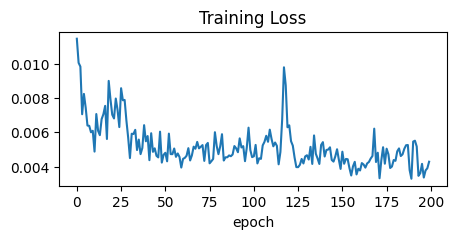

In [ ]:
plt.figure(figsize=(5, 2))
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
checkpoint = torch.load ('./models/reg4-1.pt')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
loss_ = checkpoint['loss']
ep = checkpoint['epoch']
ls = loss_[-1]
print(f"epoch={ep}, loss={ls}")

epoch=379, loss=0.0032960587413981557


## 4.7 모델 평가

In [ ]:
def rmse(dataloader):
        
    with torch.no_grad(): # requires_grad: 비활성화
        square_sum = 0
        num_instances = 0
        model.eval() # 평가를 할 때에는 .eval() 반드시 사용해야 한다.
        for data in dataloader:
            inputs, targets = data
            outputs = model(inputs)
            square_sum += torch.sum((outputs - targets)**2).item()
            num_instances += len(targets)

    model.train()
    return np.sqrt(square_sum/num_instances)  

# 평가 시 .eval()을 사용해야 하는 이유
# 평가 시에는 정규화 기술을 배제하여 온전한 모델로 평가를 해야한다. 따라서 .eval()을 사용한다.
# 즉, 드랍아웃이나 배치 정규화 등과 같이 학습 시에만 사용하는 기술들이 적용 된 모델은 평가 시에는 비활성화 해야하며 학습 시 .train()을 사용한다.

In [ ]:
train_rmse = rmse(trainloader) # 학습 데이터의 RMSE
test_rmse = rmse(testloader) # 시험 데이터의 RMSE

print("Train RMSE: %.5f" %train_rmse)
print("Test RMSE: %.5f" %test_rmse)

# 예시를 위한 단순 비교입니다. 실제 연구에서는 디테일한 비교가 필요합니다.
# 예를 들어 20번의 평가 결과의 평균과 표준편차로 우위 비교를 하거나 신뢰구간을 이용합니다.
# 데이터를 무작위로 나누고 모델의 초기값도 random initial parameter를 사용했기 때문에 학습을 할 때 마다 결과가 다르게 나올 수 있습니다.
# 이 강의에서는 학습의 흐름(for문)과 모델(Regressor) 부분을 주의 깊게 보시면 됩니다.

Train RMSE: 0.04959
Test RMSE: 0.10834
